这章很多包更新了，建议看ml3的代码

https://github.com/ageron/handson-ml3/blob/main/18_reinforcement_learning.ipynb

In [14]:
import gym
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']

# 简单环境

In [15]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
# 渲染模式除非有策略连续指导，否则最好用rgb_array像素张量，再用plt.imshow()作图
obs = env.reset()


In [16]:
obs  # 水平位置（0是中心），速度（右正），垂直角度，角速度


(array([-0.00385072,  0.01327342, -0.02109975,  0.02396061], dtype=float32),
 {})

In [17]:
img = env.render()  # 返回图像像素的数组


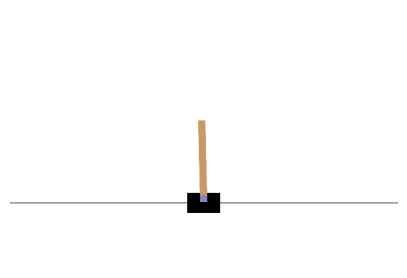

In [18]:
def plot_environment(env, figsize=(5, 4)):  # 显示图像
    plt.figure(figsize=figsize)
    img = env.render()
    plt.imshow(img)
    plt.axis("off")
    return img


plot_environment(env)
plt.show()


In [19]:
img.shape

(400, 600, 3)

In [20]:
env.action_space  # 可采取的行动


Discrete(2)

0是向左加速，1 是向右加速

In [21]:
action = 1  # 向右加速


In [22]:
obs, reward, done, truncated, info = env.step(
    action)  # 新状态，奖励，是否回合结束，是否截断（不懂），其他信息


In [23]:
obs

array([-0.00358526,  0.20869151, -0.02062054, -0.27530414], dtype=float32)

In [24]:
env.close()

# 硬代码方案

杆子向左倾斜时左移，向右倾斜时右移

In [25]:
env = gym.make("CartPole-v1", render_mode="human")
obs = env.reset()[0]
env.render()


def basic_policy(obs):  # 硬代码方法
    angle = obs[2]  # 获得杆子角度，向右是正
    return 0 if angle < 0 else 1  # 向左倾斜时左移，向右倾斜时右移


totals = []
for episode in range(30):  # 训练30回合
    episode_rewards = 0
    obs = env.reset()[0]
    for step in range(200):  # 每回合200步
        action = basic_policy(obs)
        obs, reward, done, truncated, info = env.step(action)
        episode_rewards += reward
        if done:
            break
    totals.append((episode_rewards))
env.close()


In [26]:
env.close()

In [27]:
np.mean(totals), np.std(totals), np.min(totals), np.max(totals)

(40.8, 8.243785538209979, 25.0, 62.0)

# 梯度策略（Policy Gradient，PG算法）

In [28]:
import tensorflow as tf
from tensorflow import keras


In [29]:
n_inputs = 4  # 四个输入状态, step()是5个游戏状态, obs是4个环境状态


keras模型

In [30]:
model = keras.Sequential(
    [
        keras.layers.Dense(5, activation="elu", input_shape=[n_inputs]),
        keras.layers.Dense(1, activation="sigmoid"),
    ]
)


单步执行函数

In [9]:
def play_one_step(env, obs, model, loss_fn):  # 执行一个动作，返回4个状态和梯度
    """根据目前状态选择动作"""
    with tf.GradientTape() as tape:  # 自动微分
        left_proba = model(obs[np.newaxis])  # 初始模型预测向左的概率，x输入模型时加一个维度
        action = tf.random.uniform([1, 1]) > left_proba  # 动作为布尔值True or Flase
        y_target = tf.constant([[1.0]]) - tf.cast(action,
                                                  tf.float32)  # cast()转换数据格式
        # action为True->1，应该向左走，因此实际上要通过1-action转换为0，但只是为了算损失，下一步直接用action转换
        # 损失（张量）均值，*假设每次动作都是对的*
        loss = tf.reduce_mean(loss_fn(y_target, left_proba))
    grads = tape.gradient(loss, model.trainable_variables)  # 计算梯度
    obs, reward, done, truncated, info = env.step(
        int(action[0, 0].numpy()))  # 采取动作
    return obs, reward, done, truncated, grads


In [32]:
left_proba = model(obs[np.newaxis])


In [33]:
action = tf.random.uniform([1, 1]) > left_proba


多轮执行函数

In [34]:
def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):  # 轮数
        current_rewards = []
        current_grads = []
        obs, info = env.reset()  # 初始化
        for step in range(n_max_steps):  # 执行若干回合
            obs, reward, done, truncated, grads = play_one_step(
                env, obs, model, loss_fn
            )
            current_rewards.append(reward)
            current_grads.append(grads)
            if done or truncated:
                break
        all_rewards.append(current_rewards)
        all_grads.append(current_grads)
    return all_rewards, all_grads


# 返回每一轮每一回合每一步的奖励数，和每一步的梯度张量


对奖励进行打折，越往后折扣越大，并且进行标准化

In [35]:
def discount_rewards(rewards, discount_factor):
    discounted = np.array(rewards, dtype=float)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_factor
        # 从倒数第二项开始逐个乘以折扣，一直到第一个
    return discounted


def discount_and_normalize_rewards(all_rewards, discount_factor):
    all_discounted_rewards = [
        discount_rewards(rewards, discount_factor) for rewards in all_rewards
    ]  # 对奖励应用折扣
    flat_rewards = np.concatenate(all_discounted_rewards)  # 纵向拼接
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [
        (discount_rewards - reward_mean) / reward_std
        for discount_rewards in all_discounted_rewards
    ]  # 返回标准化的折扣奖励


设定参数

In [63]:
n_iterations = 85  # 迭代次数
n_episodes_per_update = 10  # 每次迭代10回合
n_max_steps = 200  # 每回合最多训练200步
discount_factor = 0.95  # 折扣因子


指定优化器和损失函数

In [64]:
optimizer = keras.optimizers.Adam(0.01)
loss_fn = keras.losses.binary_crossentropy  # 二元交叉熵


训练方案

In [65]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
for iteration in range(n_iterations):
    # 执行一次迭代，即玩10回合，每回合最多200步，返回所有奖励和梯度
    all_rewards, all_grads = play_multiple_episodes(
        env, n_episodes_per_update, n_max_steps, model, loss_fn
    )

    # 打印每一次迭代数据
    total_rewards = sum(map(sum, all_rewards))
    print(
        f"\rIteration: {iteration + 1}/{n_iterations},"
        f" mean rewards: {total_rewards / n_episodes_per_update:.1f}",
        end="",
    )

    # 奖励打折
    all_final_rewards = discount_and_normalize_rewards(all_rewards, discount_factor)

    # 更新梯度的计算
    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)):  # 循环可训练的四个张量索引值
        mean_grads = tf.reduce_mean(
            [
                final_reward * all_grads[episode_index][step][var_index]
                for episode_index, final_rewards in enumerate(all_final_rewards)
                for step, final_reward in enumerate(final_rewards)
            ],
            axis=0,
        )
        # 折扣奖励（权重）乘以对应的梯度张量，episode_index和step索引出张量列表，var_index为列表四个张量索引
        # all_final_rewards 中有10个[列表]，存有每一轮的折扣后奖励，每个列表在后面的for循环提取👇
        # final_reward 是上一轮从 all_final_rewards 中提取出来的[列表]👆
        # all_grads 长度为10，代表10次训练，装有每次训练中可训练参数的梯度，每次训练的梯度有四个张量：
        # 1. (4(输入维度), 5(输入权重))； 2.(5(偏置项), )； 3.(5(输出权重), 1)； 4.(1(输出偏置), )
        # 总之，两次内循环都是为了提取final_reward并且获得索引，外循环对应训练张量all_grads

        all_mean_grads.append(mean_grads)  # 该批次四个梯度张量更新的均值的列表

    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))  # 应用梯度更新

Iteration: 85/85, mean rewards: 193.2

In [66]:
model.predict(obs[np.newaxis])


1/1 [==============================] - 0s 31ms/step


array([[0.9865063]], dtype=float32)

保存模型

In [67]:
model.save("E:/机器学习实战/机器学习实战笔记/model/RL_PG.h5")

读取模型

In [39]:
model = keras.models.load_model("models/RL_PG.h5")

# 🎉 演示PG策略效果

In [40]:
def show_pg_policy(policy, epochs=10):
    env = gym.make("CartPole-v1", render_mode="human")
    totals = []
    for i in range(epochs):  # 测试轮数
        episode_rewards = 0
        obs = env.reset()[0]  # 第二个输出为info，可以不要
        for _ in range(300):  # 每回合最多300步
            left_proba = policy(obs[np.newaxis])  # 初始模型预测向左的概率，x输入模型时加一个维度
            action = tf.random.uniform([1, 1]) > left_proba  # 动作为布尔值True or Flase
            obs, reward, done, truncated, info = env.step(int(action[0, 0].numpy()))
            episode_rewards += reward
            if done or truncated:
                break
        totals.append((episode_rewards))
    env.close()
    return totals

In [41]:
reward = show_pg_policy(model)


In [72]:
reward


[300.0, 108.0, 300.0, 300.0, 300.0, 152.0, 300.0, 148.0, 300.0, 300.0]

## 如何理解PG算法

1. 在每一步中，假设每一步动作都是对的，用神经网络估计出采取该动作的概率，并且计算最终采取的动作和概率之间的损失；进行若干次迭代，每次迭代采取几个回合，统计每一轮的最终得分和梯度（注意，梯度本身就自带若干张量，因此最终得分有两个维度，即每轮和每次迭代，而梯度也有这两个维度，但还多了一个维度包含神经网络的若干梯度张量，`用这句话理解最后训练中的梯度更新`）。

2. 要对得分进行标准化，因此表现不佳的情况会变为负数，用它乘以梯度更新，就把原本的损失转化为正向或反向的梯度更新。

3. 一次迭代之后会获得多个维度（轮次）的数据，此时再进行梯度更新（离线学习）

4. 计算梯度可以使用`tf`的自动微分，优化器和损失函数也可以用`tf`的函数指定。

# 马尔可夫决策过程（MDP）

一种马尔科夫链

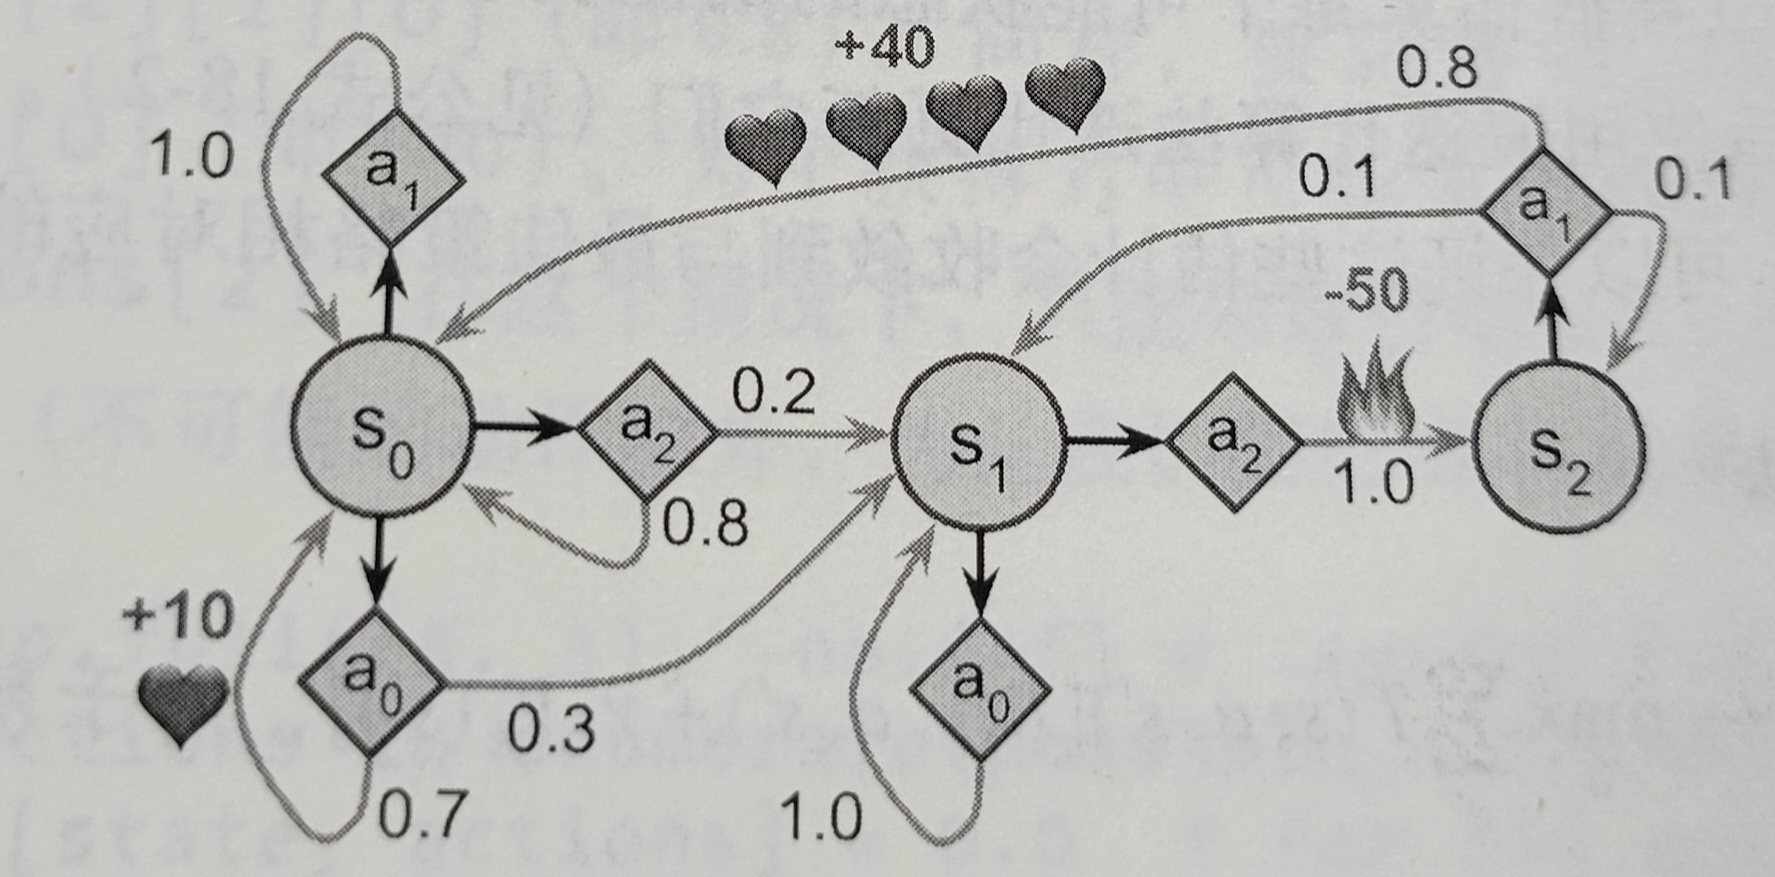

In [45]:
transition_probabilities = [  # shape=[s, a, s']
    [[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]],
    [[0.0, 1.0, 0.0], None, [0.0, 0.0, 1.0]],
    [None, [0.8, 0.1, 0.1], None],
]
rewards = [  # shape=[s, a, s']
    [[+10, 0, 0], [0, 0, 0], [0, 0, 0]],
    [[0, 0, 0], [0, 0, 0], [0, 0, -50]],
    [[0, 0, 0], [+40, 0, 0], [0, 0, 0]],
]
possible_actions = [[0, 1, 2], [0, 2], [1]]

Q值迭代法

由贝尔曼方程得到的Q值迭代算法公式：

$Q_{k+1}\leftarrow \sum_{s'}T(s,a,s')[R(s,a,s')+\gamma*~max_{a'}~[Q_k(s',a')]]$ ，对于所有$(s',a')$

T(s,a,s')是从状态s到s'的概率，R(s,a,s')是转移获得的奖励，$max_{a'}~[Q_k(s',a')]$是本轮和后面的每一轮中可以获得的最大奖励，即假定后面每一步都按照最好的`历史记录`采取动作

In [46]:
Q_values = np.full((3, 3), -np.inf)  # 对所有动作给负无穷
for state, actions in enumerate(possible_actions):
    Q_values[state, actions] = 0.0  # 对于可能的动作给0


In [47]:
Q_values


array([[  0.,   0.,   0.],
       [  0., -inf,   0.],
       [-inf,   0., -inf]])

In [48]:
gamma = 0.90  # 折扣因子

history1 = []  # 迭代的历史信息
for iteration in range(50):
    Q_prev = Q_values.copy()
    history1.append(Q_prev)  # 记录历史信息
    # 应用Q值迭代算法
    for s in range(3):
        for a in possible_actions[s]:
            Q_values[s, a] = np.sum(
                [
                    transition_probabilities[s][a][sp]
                    * (rewards[s][a][sp] + gamma * Q_prev[sp].max())
                    for sp in range(3)
                ]
            )

history1 = np.array(history1)  # 整理历史信息

In [49]:
Q_values


array([[18.91891892, 17.02702702, 13.62162162],
       [ 0.        ,        -inf, -4.87971488],
       [       -inf, 50.13365013,        -inf]])

In [50]:
Q_values.argmax(axis=1)  # 每一步采取获得最大值的动作的序号

array([0, 0, 1], dtype=int64)

In [51]:
history1 = np.array(history1)


马尔可夫决策过程，即Q值迭代法，需要预先知道动作转移的概率，奖励和可以做的动作，然而现实情况下，动作转移概率很难提前得知

# 时序差分学习

一般来说有蒙特卡洛法和时序差分法，蒙特卡洛法计算误差是通过多步的回报之和，计算的是多步价值和预测价值的误差，时序差分法则是在每一步进行误差计算，计算的是本轮获得的奖励`r`的误差

# Q学习

在不知道动作转移概率的情况下，让智能体随机选择动作，从而改善对Q值的估计

$Q(s,a)\leftarrow~(1-\alpha)r+\alpha(\gamma~*max_a Q(s',a'))$

$r$是采取动作a获得的奖励的移动平均值，$\gamma~*max_a Q(s',a')$是折扣未来报酬之和

In [52]:
# 步骤函数
def step(state, action):
    probas = transition_probabilities[state][action]
    next_state = np.random.choice([0, 1, 2], p=probas)
    reward = rewards[state][action][next_state]
    return next_state, reward


In [53]:
# 随机选择一个动作
def exploration_policy(state):
    return np.random.choice(possible_actions[state])


In [54]:
np.random.seed(42)
# 初始化Q表
Q_values = np.full((3, 3), -np.inf)
for state, actions in enumerate(possible_actions):
    Q_values[state][actions] = 0


In [55]:
# 转移概率
transition_probabilities = [  # shape=[s, a, s']
    [[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]],
    [[0.0, 1.0, 0.0], None, [0.0, 0.0, 1.0]],
    [None, [0.8, 0.1, 0.1], None],
]

In [56]:
alpha0 = 0.05  # 初始学习率
decay = 0.005  # 学习率衰减
gamma = 0.90  # 折扣因子
state = 0  # 初始状态
history2 = []  # 历史Q表
al_history = []

for iteration in range(10_000):
    history2.append(Q_values.copy())  # 增加历史记录
    action = exploration_policy(state)  # 随机选择动作
    next_state, reward = step(state, action)  # 采取动作，获得下一个状态

    next_value = Q_values[next_state].max()  # 贪婪策略，直接选择Q值最高的动作，或者设置一个衰减概率选择其他动作
    alpha = alpha0 / (1 + iteration * decay)  # 学习率衰减
    al_history.append(1 - alpha)
    Q_values[state, action] *= 1 - alpha  # 原先部分保留(1-alpha)，被修改的部分权重是alpha（衰减）👇
    Q_values[state, action] += alpha * (reward + gamma * next_value)
    state = next_state

history2 = np.array(history2)  # 整理Q表

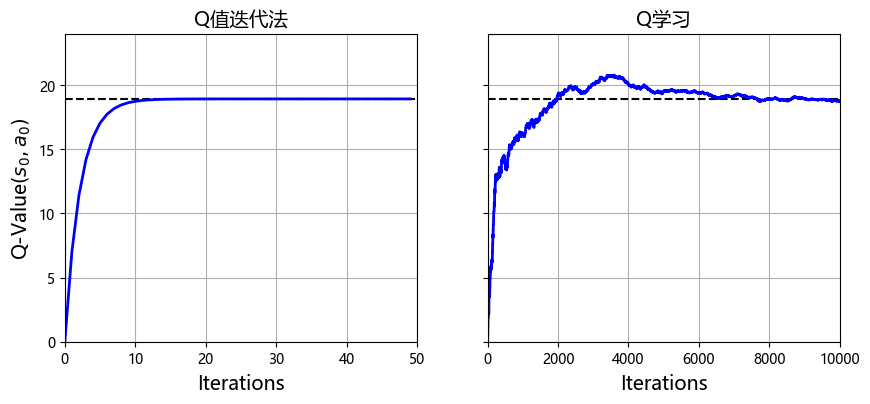

In [57]:
true_Q_value = history1[-1, 0, 0]  # 任意选一个Q值作为索引接口，该值在多次迭代后将稳定

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
axes[0].set_ylabel("Q-Value$(s_0, a_0)$", fontsize=14)
axes[0].set_title("Q值迭代法", fontsize=14)
axes[1].set_title("Q学习", fontsize=14)
for ax, width, history in zip(axes, (50, 10000), (history1, history2)):
    ax.plot([0, width], [true_Q_value, true_Q_value], "k--")
    ax.plot(np.arange(width), history[:, 0, 0], "b-", linewidth=2)  # 对应基准Q值索引
    ax.set_xlabel("Iterations", fontsize=14)
    ax.axis([0, width, 0, 24])
    ax.grid(True)
plt.savefig('pictures/RL_01.jpg')
plt.show()

Q学习经过几千次迭代效果才与Q迭代法类似，不知道转移概率会使找到最佳策略很困难

# 近似Q学习和深度Q学习（DQN）

# 🎉 演示DQN策略函数效果

In [70]:
def show_DQN_policy(model, epochs=10):
    env = gym.make("CartPole-v1", render_mode="human")
    totals = []
    for i in range(epochs):  # 测试轮数
        episode_rewards = 0
        obs = env.reset()[0]  # 第二个输出为info，可以不要
        for _ in range(300):  # 每回合最多300步
            Q_values = model.predict(obs[np.newaxis], verbose=0)[0]
            action = np.argmax(Q_values)
            obs, reward, done, truncated, info = env.step(action)
            episode_rewards += reward
            if done or truncated:
                break
        totals.append((episode_rewards))
    env.close()
    return totals

## 🔺导入库

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import gym
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
tf.config.list_logical_devices()

[LogicalDevice(name='/device:CPU:0', device_type='CPU'),
 LogicalDevice(name='/device:GPU:0', device_type='GPU')]

In [2]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on the CPU

input_shape = [4]  # == env.observation_space.shape
n_outputs = 2  # == env.action_space.n

model = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(32, activation="elu", input_shape=input_shape),
        tf.keras.layers.Dense(32, activation="elu"),
        tf.keras.layers.Dense(n_outputs),
    ]
)

## 🔺贪婪策略

In [2]:
def epsilon_greedy_policy(model ,state, epsilon=0):  # epsilon设定贪婪度，越高则越选择Q值高的动作
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs)  # 在1-epsilon概率下随机选择动作
    else:
        Q_values = model.predict(state[np.newaxis], verbose=0)[0] # 出来之后应该有两个维度，去掉一个方便后续
        return Q_values.argmax()  # DQN给出的Q值最高的动作索引

## 🔺导入双端链表

In [3]:
from collections import deque

# 重播缓存
replay_buffer = deque(maxlen=2000)  # 长度2000的双端列表，性质类似list但是处理复杂度更低

## 🔺经验采样

In [4]:
def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_buffer), size=batch_size)
    # 0~2000的均匀分布，抽取大小为batch_size的随机数组
    batch = [replay_buffer[index] for index in indices]  # 按随机序号抽取缓存中的经验
    return [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(6)
    ]  # [states, actions, rewards, next_states, dones, truncateds] 每个元素是一个ndarray数组

## 🔺执行单步

In [5]:
def play_one_step(model, env, state, epsilon):
    action = epsilon_greedy_policy(model, state, epsilon)
    next_state, reward, done, truncated, info = env.step(action)
    replay_buffer.append(
        (state, action, reward, next_state, done, truncated)
    )  # 经验缓存中增加经验
    return next_state, reward, done, truncated, info

In [6]:
# 初始化
env = gym.make("CartPole-v1", render_mode="rgb_array")
env.reset(seed=42)
np.random.seed(42)
tf.random.set_seed(42)
rewards = []
best_score = 0

batch_size = 32
discount_factor = 0.95
optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-2)  # 优化器
loss_fn = tf.keras.losses.mean_squared_error  # 损失函数mse

In [16]:
def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones, truncateds = experiences
    next_Q_values = model.predict(next_states, verbose=0) # 输出该批次每个经验中采取两个动作获得的Q值对
    # verbose为0不输出日志，为1有进度条和日志，2为无进度条有日志
    max_next_Q_values = next_Q_values.max(axis=1)  # 选出预测的两个动作中最大的Q值，另一个去掉
    runs = 1.0 - (dones | truncateds)  # 回合未结束或未出界则加上折扣分，否则不加分
    target_Q_values = rewards + runs * discount_factor * max_next_Q_values
    # 本轮获得的奖励加上折扣的下一轮最大Q值，得到本轮Q值的目标，这里reward是已知的，是采取特定动作后已经看到的结果
    target_Q_values = target_Q_values.reshape(-1, 1)  # 把Q值展平
    mask = tf.one_hot(actions, n_outputs)
    # 2个动作（有32组，batch_size），2个输出（在前面定义的），第二个参数控制维度（每组）
    # 因为模型输出的价值是[[a1, a2], ...]的结构，因此动作转独热编码变成类似[[1, 0], ...]的结构并相乘
    # 可以去掉那些不需要的动作的Q值
    
    with tf.GradientTape() as tape:
        all_Q_values = model(states)  # 得到预测的本轮两个动作的Q值，也可以写成model.predict(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        # 把预测的Q值和掩码相乘，去掉不需要的Q值，在轴1上求和，得到一个Q值张量
        # 为什么目标Q值不需要？因为那是已知的一个动作对应的一个Q值（一组），而预测Q值有两个可能的动作对应的Q值
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))  # 平均的均方误差
    # 【还有，为什么tape在with外面用？？？】
    grads = tape.gradient(loss, model.trainable_variables)  # 计算梯度
    optimizer.apply_gradients(zip(grads, model.trainable_variables))  # 梯度下降

In [ ]:
for episode in range(600): # 600回合
    obs, info = env.reset()
    for step in range(200): # 执行最多200步
        epsilon = max(1 - episode / 500, 0.01) # 功率调节，最小是0.01，线性降低
        obs, reward, done, truncated, info = play_one_step(model, env, obs, epsilon) 
        if done or truncated:
            break
    # 显示信息并且应用最佳权重 #
    print(f"\rEpisode: {episode + 1}, Steps: {step + 1}, ε: {epsilon:.3f}",
          end="")
    rewards.append(step) # 记录本回合最终分数
    if step >= best_score: # 最终步骤数实际上等于奖励分数
        best_weights = model.get_weights() # 获得本回合的权重
        best_score = step # 保留该回合最高分

    if episode > 50: # 50个回合之后再训练，目的是先增加经验，但是具体加了多少不确定，因为每回合步骤几乎是随机的
        training_step(batch_size)

model.set_weights(best_weights)  # 把最佳权重赋值到模型

In [25]:
model.save('models/RL_DQN.h5')

In [68]:
model = keras.models.load_model('models/RL_DQN.h5')

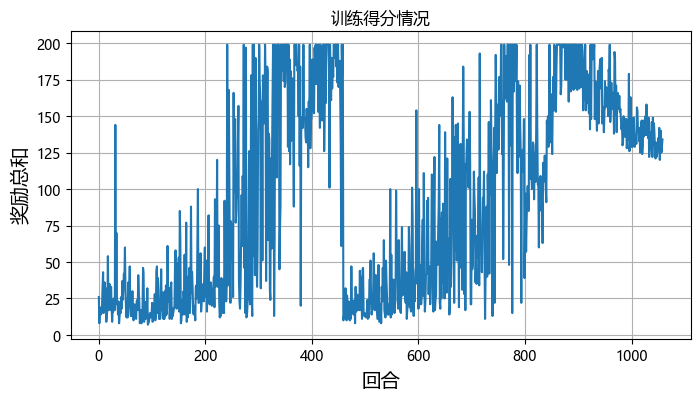

In [32]:
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("回合", fontsize=14)
plt.ylabel("奖励总和", fontsize=14) # 坚持一步就是一分，最多200步
plt.grid(True)
plt.title('训练得分情况')
plt.savefig('pictures/RL_02.jpg')

## 演示DQN效果

In [69]:
show_DQN_policy(model)

[174.0, 136.0, 187.0, 143.0, 157.0, 156.0, 188.0, 185.0, 151.0, 157.0]

## 如何理解DQN

先通过贪婪策略用模型让模型对初始状态随机产生一些动作（因为未经训练）并且获得结果，把这些称为经验并且存起来，经验列表长度2000，因此先运行50个回合，每一回合的步骤是几乎随机的，假如每个回合有30步，那么50回合就有1500步，就有1500个经验被加到列表中，没填满不用担心，因为抽经验是在现有长度内抽的随机数。有了经验以后就随机抽取经验训练模型（`training_step()`），每次抽的都是一个状态、行为等信息的数据组，让DQN预测下一状态（`next_states`）的Q值，用贝尔曼公式得出本轮的目标Q值` = 本轮奖励r + 折扣因子 * 下一轮的预测Q值`，再用DQN预测本轮(`states`)的Q值，通过这两个Q值的误差训练模型。

## 注意点

这里不用损失来衡量效果，在这种情况下，损失可能减小或者增大，而智能体的性能可能反而变差或者变好

# 双DQN （Double DQN）

In [8]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on the CPU

input_shape = [4]  # == env.observation_space.shape
n_outputs = 2  # == env.action_space.n

model_double_dqn = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(32, activation="elu", input_shape=input_shape),
        tf.keras.layers.Dense(32, activation="elu"),
        tf.keras.layers.Dense(n_outputs),
    ]
)
# 初始化
env = gym.make("CartPole-v1", render_mode="rgb_array")
env.reset(seed=42)
np.random.seed(42)
tf.random.set_seed(42)
rewards = []
best_score = 0

batch_size = 32
discount_factor = 0.95
optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-2)  # 优化器
loss_fn = tf.keras.losses.mean_squared_error  # 损失函数mse

由于DQN计算Q值也用一样的模型，即被不断修改的，因此被估计的Q值可能更大，因此用一个一样的另一个模型估计Q值，仅50回合更新一次权重，而动作还是用原来的模型先估计动作Q值再确定动作，其他部分几乎完全一样

In [12]:
##### 克隆一个模型 ######
target = tf.keras.models.clone_model(model_double_dqn)  # 复制一个新的模型（初始状态一致）
target.set_weights(model_double_dqn.get_weights())  # 应用权重
#######################

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones, truncateds = experiences

    #################### 修改部分 ####################
    next_Q_values = model_double_dqn.predict(next_states, verbose=0)  # ≠ target.predict()
    best_next_actions = next_Q_values.argmax(axis=1) # 直接取动作而非Q值
    next_mask = tf.one_hot(best_next_actions, n_outputs).numpy()
    max_next_Q_values = (target.predict(next_states, verbose=0) * next_mask
                        ).sum(axis=1) # 计算Q值使用目标模型
    #################################################

    runs = 1.0 - (dones | truncateds)
    target_Q_values = rewards + runs * discount_factor * max_next_Q_values
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model_double_dqn(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))

    grads = tape.gradient(loss, model_double_dqn.trainable_variables)
    optimizer.apply_gradients(zip(grads, model_double_dqn.trainable_variables))

In [13]:
for episode in range(500): # 600回合
    obs, info = env.reset()
    for step in range(200): # 执行最多200步
        epsilon = max(1 - episode / 500, 0.01) # 功率调节，最小是0.01，线性降低
        obs, reward, done, truncated, info = play_one_step(model_double_dqn, env, obs, epsilon) 
        if done or truncated:
            break
    # 显示信息并且应用最佳权重 #
    print(f"\rEpisode: {episode + 1}, Steps: {step + 1}, ε: {epsilon:.3f}",
          end="")
    rewards.append(step) # 记录本回合最终分数
    if step >= best_score: # 最终步骤数实际上等于奖励分数
        best_weights = model_double_dqn.get_weights() # 获得本回合的权重
        best_score = step # 保留该回合最高分

    if episode > 50: # 50个回合之后再训练，目的是先增加经验，但是具体加了多少不确定，因为每回合步骤几乎是随机的
        training_step(batch_size)
        if episode % 50 == 0: ##### 50回合修改一次目标模型的权重 #####
            target.set_weights(model_double_dqn.get_weights())

model_double_dqn.set_weights(best_weights)  # 把最佳权重赋值到模型

Episode: 500, Steps: 112, ε: 0.010

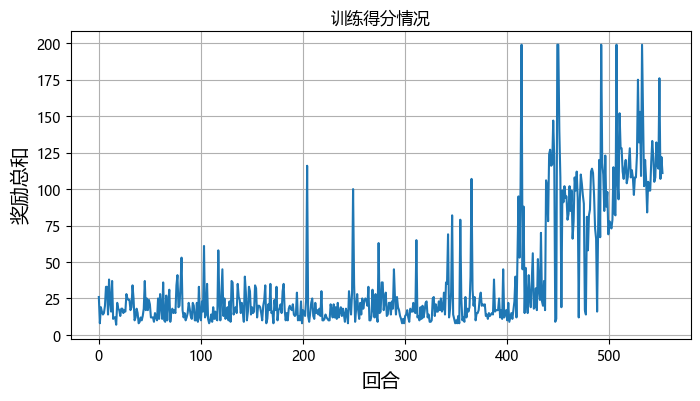

In [14]:
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("回合", fontsize=14)
plt.ylabel("奖励总和", fontsize=14) # 坚持一步就是一分，最多200步
plt.grid(True)
plt.title('训练得分情况')
plt.savefig('pictures/RL_03.jpg')

In [15]:
model_double_dqn.save('models/RL_Double_DQN.h5')

In [16]:
model_double_dqn = keras.models.load_model('models/RL_Double_DQN.h5')

In [17]:
show_DQN_policy(model_double_dqn)

[281.0, 300.0, 199.0, 253.0, 188.0, 300.0, 173.0, 202.0, 208.0, 195.0]

效果一般

# 重要经验重播

对误差大的经验给一个较高的概率被抽取，比如用一个概率参数调整，但是可能导致被重复抽取很多次，因此还要降低重要经验的训练权重，用一个权重参数调整，而这两个参数本身也可以调节。

# 竞争DQN（Deuling DQN / DDQN）

In [39]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

一个简单的DDQN模型，用函数式API生成

In [40]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on the CPU

input_states = tf.keras.layers.Input(shape=[4])
hidden1 = tf.keras.layers.Dense(32, activation="elu")(input_states)
hidden2 = tf.keras.layers.Dense(32, activation="elu")(hidden1)
state_values = tf.keras.layers.Dense(1)(hidden2)
raw_advantages = tf.keras.layers.Dense(n_outputs)(hidden2)
advantages = raw_advantages - tf.reduce_max(raw_advantages, axis=1,
                                            keepdims=True)
Q_values = state_values + advantages
model_ddqn = tf.keras.Model(inputs=[input_states], outputs=[Q_values])

## DDQN 思路

有两个隐藏层，但在第三层给出两个输出，一个输出V(s)一个输出A(s,a)，最终输出V(s)+A(s,a)，V代表当前状态的价值，A是当前状态s采取动作a获得的优势，假设最佳策略会采取最佳动作，因此要让V=Q(s,a*)，a\*代表最佳动作，也就相当于A(s,a\*)等于0，在神经网络中增加对A的约束，让原来的A减去所有A中最大的值

In [41]:
target = keras.models.clone_model(model_ddqn)
target.set_weights(model_ddqn.get_weights())

In [42]:
model_ddqn.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 4)]          0           []                               
                                                                                                  
 dense (Dense)                  (None, 32)           160         ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 32)           1056        ['dense[0][0]']                  
                                                                                                  
 dense_3 (Dense)                (None, 2)            66          ['dense_1[0][0]']                
                                                                                              

后面写法不变

In [54]:
batch_size = 32
discount_rate = 0.95
optimizer = keras.optimizers.Adam(learning_rate=7.5e-3)
loss_fn = keras.losses.Huber()

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones, truncateds = experiences
    next_Q_values = model_ddqn.predict(next_states, verbose=0)
    best_next_actions = np.argmax(next_Q_values, axis=1)
    next_mask = tf.one_hot(best_next_actions, n_outputs).numpy()
    next_best_Q_values = (target.predict(next_states, verbose=0) * next_mask).sum(axis=1)
    target_Q_values = (rewards + 
                       (1 - dones) * discount_rate * next_best_Q_values)
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model_ddqn(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model_ddqn.trainable_variables)
    optimizer.apply_gradients(zip(grads, model_ddqn.trainable_variables))

In [55]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
env.reset(seed=42)
np.random.seed(42)
tf.random.set_seed(42)
rewards = []
best_score = 0

replay_memory = deque(maxlen=2000)

for episode in range(600):
    obs, info = env.reset()    
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, truncated, info = play_one_step(model_ddqn ,env, obs, epsilon)
        if done or truncated:
            break

    print(f"\rEpisode: {episode + 1}, Steps: {step + 1}, eps: {epsilon:.3f}",
          end="")
    rewards.append(step)
    if step >= best_score:
        best_weights = model_ddqn.get_weights()
        best_score = step

    if episode > 50:
        training_step(batch_size)
        if episode % 50 == 0:
            target.set_weights(model_ddqn.get_weights())

model_ddqn.set_weights(best_weights)

Episode: 600, Steps: 12, eps: 0.0100

In [56]:
model_ddqn.save('models/RL_DDQN.h5')

In [ ]:
model_ddqn = keras.models.load_model('models/RL_DDQN.h5')

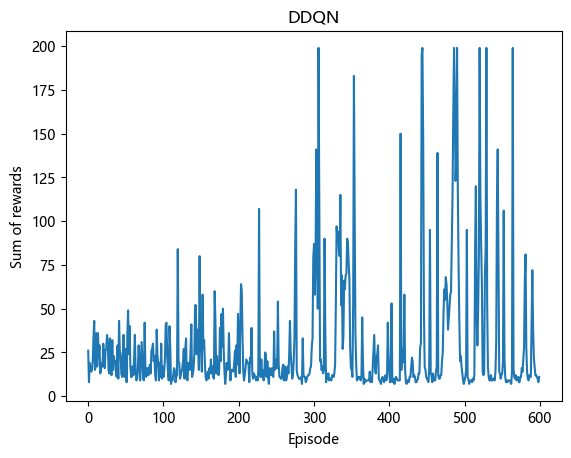

In [66]:
plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Sum of rewards")
plt.title('DDQN')
plt.show()

## 演示DDQN效果

In [71]:
show_DQN_policy(model_ddqn)

total reward per epoch:


[98.0, 300.0, 300.0, 123.0, 242.0, 203.0, 174.0, 196.0, 268.0, 124.0]

# TF-Agents